Here I create a dataset which follows a lognormal distribution, truncate it, and then use pymc3 to try and recover the original parameters used to make the dataset.

In [1]:
# imports
%matplotlib inline 

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pymc3 as pm
import time
from pymc3.distributions.dist_math import normal_lcdf, normal_lccdf
import theano.tensor as tt
plt.rcParams["font.family"] = "Times New Roman"
import scipy.stats as st

# "Original Population" - lognormal distribution

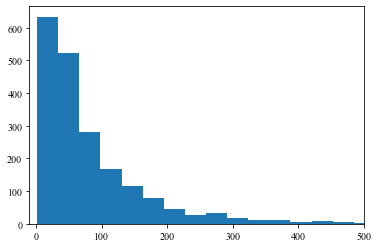

In [2]:
n = 2000
mean = 4
sigma = 1

population = np.random.lognormal(mean=mean, sigma=sigma, size=n)
plt.hist(population, bins=100);
plt.xlim(-10, 500);

### Truncating it

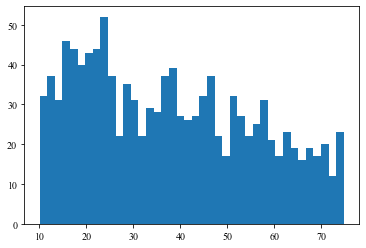

In [3]:
maximum = 75
minimum = 10
data_trunc = population[((population<maximum)&(population>minimum))]
plt.hist(data_trunc, bins=40);

### Now trying to recover the original parameters with Pymc3

In [4]:
err = 1

def pymc3_trunc_fit(data, tune=1000, nsteps=1000, random_seed=0):


    with pm.Model() as hierarchical_model:

        # PRIORS
        # -------------
        # (for normal disribution of log of separations)
        width = pm.Gamma('width', mu=1.1, sigma=0.5)
        center = pm.Gamma('center', mu=5, sigma=3)
        
        
        # MODEL OF POPULATION
        # --------------
        sep_physical = pm.Lognormal('sep_physical', mu=center, sigma=width, shape=len(data))
    
    
        # LIKELIHOODS, WITH MEASUREMENT ERROR
        # -----------------
        sep_observed = pm.Normal('sep_observed', mu=sep_physical, sigma=err, observed=data)
        
        
        # ACCOUNTING FOR TRUNCATION
        # ------------------
        # integrate out the points which fall outside of the observation limits from the likelihood
        # pm.Potential accounts for truncation and normalizes likelihood
        truncated_seps = pm.Potential(
            'truncated_seps',
            -pm.math.logdiffexp(normal_lcdf(sep_physical, err, maximum),
                                normal_lcdf(sep_physical, err, minimum)))
        
        # RUNNING THE FIT
        # -------------------
        traces = pm.sample(tune=tune, draws=nsteps, step=None, chains=1, random_seed=random_seed)
        
        # output as dataframe
        df = pm.trace_to_dataframe(traces)
    return traces, df

In [5]:
ta = time.time()
trcs, samples = pymc3_trunc_fit(data_trunc, nsteps=1000)
tb = time.time()
print('Fit finished, took ',round((tb -ta)/60., 1),' minutes' )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sep_physical, center, width]
Sampling chain 0, 0 divergences: 100%|█████| 2000/2000 [01:08<00:00, 29.24it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Fit finished, took  1.3  minutes


In [6]:
# estimate of the MAP
q = samples.quantile([0.16,0.50,0.84], axis=0)
c_lower, c, c_upper = q['center']
w_lower, w, w_upper = q['width']

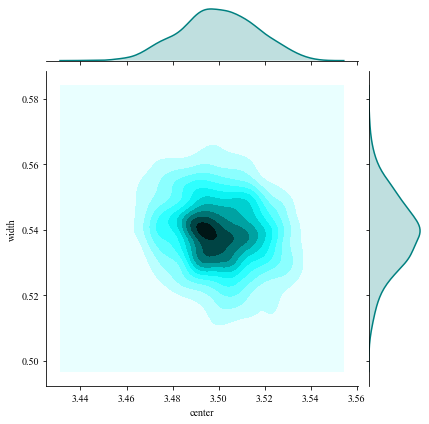

In [7]:
sns_plot = sns.jointplot(x='center', y='width', data=samples, kind='kde', color='teal');

In [8]:
def plot_lognorm(mu, sigma, data, bins, label):
    xs = np.linspace(0, np.max(data), 1000)
    pdfn = st.lognorm.pdf(xs, sigma, scale=np.exp(mu))
    normedy = len(data)*np.diff(bins)[0]*pdfn
    plt.plot(xs, normedy, label=label)

Original center: 4     Original width: 1
Fit center = 3.50 + 0.02 - 0.02
Fit width = 0.5 + 0.0 - 0.0


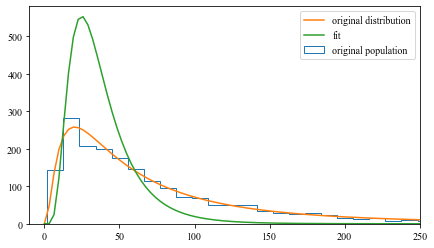

In [12]:
# testing against distributions used to make simulated data
fig = plt.figure(figsize=(7, 4))
count, bns, ignored = plt.hist(population, histtype='step', label='original population', bins=300, linewidth=1)
plot_lognorm(mean, sigma, population, bns, 'original distribution')
plot_lognorm(c, w, population, bns, 'fit')
plt.xlim(-10, 250)
plt.legend();
print('Original center:', str(mean), '    Original width:', str(sigma))
print("Fit center = {:.2f} + {:.2f} - {:.2f}".format(c, c_upper-c, c-c_lower))
print("Fit width = {:.1f} + {:.1f} - {:.1f}".format(w, w_upper-w, w-w_lower))